# HW-01, Q-02
This is the work associated with part of the homework. I already have hte dataset in the repository so I will get started immediately with the following.

For the year 2020, construct the following behavioral networks:
1. the 5cm proximity network.
2. The touch network.
3. The mating network.

For each network clean the data in the following way:
- Remove beetles with unkown identities.
- Separate beetles into different condos.

In [1]:
# Necessary imports.
import polars as pl
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
df = pl.read_csv('cook-social-2020.csv') # Load data
df.sample(5) # Just to see if everything looks right.

datetime,condo,focal_id,sex,behavior,grid_cell,cell_location,partner_id,partner_interaction
str,str,str,str,str,str,str,str,str
"""2020-08-19T15:23:00Z""","""2B""","""3SS""","""F""","""COP""","""B17""","""C""","""4AP""","""Mating Partners"""
"""2020-08-09T15:56:00Z""","""4B""","""3WP""","""F""","""S""","""W""",null,null,null
"""2018-08-11T09:34:00Z""","""3B""","""3KF""","""F""","""S""","""W""",null,null,null
"""2019-07-20T08:20:00Z""","""5B""","""3WO""","""F""","""CRT""","""C10""","""B""","""2PT""","""Mating Partners"""
"""2018-07-02T14:59:00Z""","""3A""","""3H6""","""F""","""S""","""W""",null,null,null


In [8]:
new_col = df["datetime"].str.to_datetime("%Y-%m-%dT%H:%M:%S%Z", strict=False)
df = df.replace_column(0, new_col).drop_nulls()


In [7]:
bad_values = ['UK', 'UKM', 'UKF']
df = df.filter(~pl.col("focal_id").is_in(bad_values))
df = df.filter(~pl.col("partner_id").is_in(bad_values))

In [9]:
df

datetime,condo,focal_id,sex,behavior,grid_cell,cell_location,partner_id,partner_interaction
datetime[μs],str,str,str,str,str,str,str,str
2018-06-27 06:32:00,"""6B""","""2MO""","""M""","""CRT""","""C01""","""B""","""3TL""","""Mating Partners"""
2018-06-27 06:32:00,"""6B""","""3TL""","""F""","""CRT""","""C01""","""B""","""2MO""","""Mating Partners"""
2018-06-27 06:32:00,"""6B""","""3TL""","""F""","""CRT""","""C01""","""B""","""3VX""","""5 CM Partners"""
2018-06-27 06:32:00,"""6B""","""3VX""","""F""","""S""","""C01""","""T""","""3TL""","""5 CM Partners"""
2018-06-27 06:32:00,"""6B""","""3VX""","""F""","""S""","""C01""","""T""","""2MO""","""5 CM Partners"""
…,…,…,…,…,…,…,…,…
2020-08-18 22:00:00,"""6B""","""5YN""","""F""","""CRT""","""B18""","""C""","""4K2""","""Mating Partners"""
2020-08-22 23:21:00,"""6B""","""4AW""","""M""","""CRT""","""C18""","""B""","""5AS""","""Mating Partners"""
2020-08-22 23:21:00,"""6B""","""5AS""","""F""","""CRT""","""C18""","""B""","""4AW""","""Mating Partners"""


In [ ]:
df_2020 = df.filter(pl.col('datetime').dt.year() == 2020)

# I have a function I made for Lab 02 that I can reuse here.

def network_interactions(network: str):
    # Build 'Mating Partners' network (remove isolates).
    df = df_2020.filter(pl.col('partner_interaction') == f'{network}')

    G = nx.Graph()
    G.add_nodes_from(pl.concat([df['focal_id'], df['partner_id']]).to_list())
    G.add_edges_from(df.select(["focal_id","partner_id"]).rows())

    # Removing isolates.
    G.remove_nodes_from(list(nx.isolates(G)))

    # Get the stats.
    n = G.number_of_nodes()
    m = G.number_of_edges()
    mean_deg = (sum(dict(G.degree()).values()) / n ) # sum the dict values divide by n. 
    density = (2 * m)/(n * (n-1)) # density formula
    cc = nx.average_clustering(G) # clustering coeff.

    # Draw it up.
    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, seed = 1)
    nx.draw(G, pos, node_size = 40, with_labels = False)
    plt.title(f'{network} — 2020\nNodes: {n} | Edges: {m} | Mean Deg: {mean_deg:.3f} | Density: {density:.3f} | AvgCC: {cc:.3f}')
    plt.show()



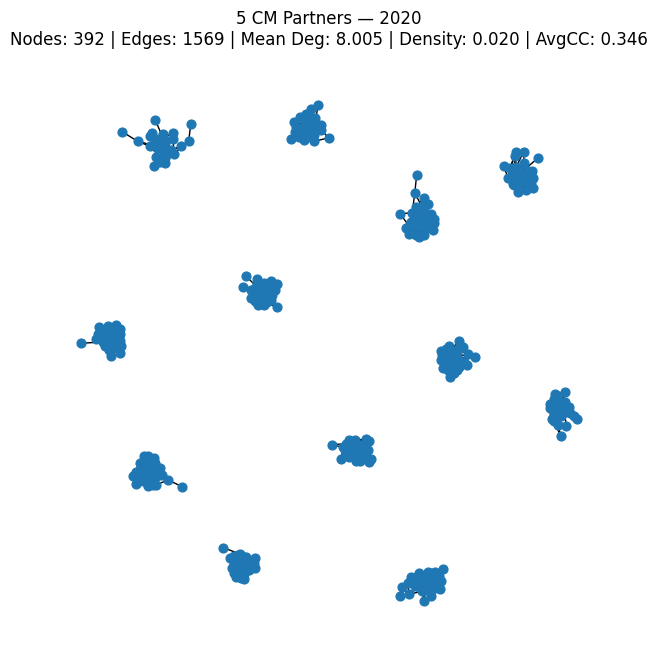

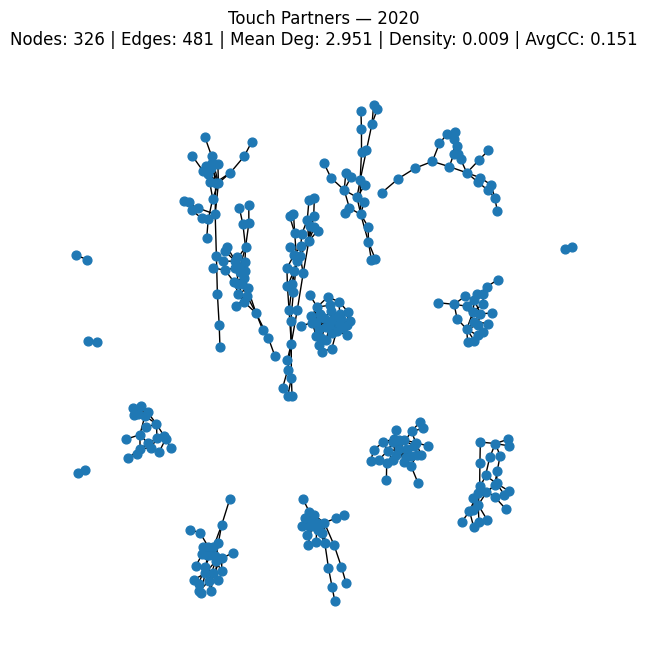

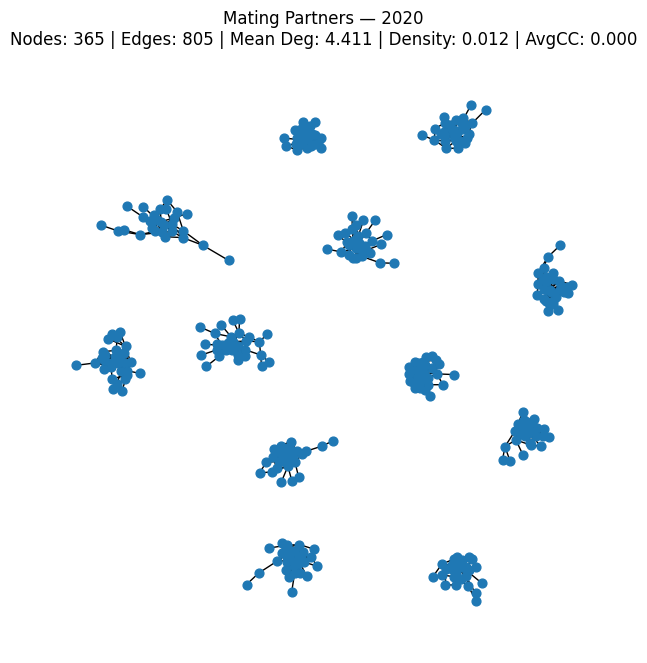

In [26]:
network_interactions('5 CM Partners')
network_interactions('Touch Partners')
network_interactions('Mating Partners')

Now, we report more network statistics:
1. Number of Nodes
2. Number of Edges
3. Minimum Degree
4. Maximum Degree
5. Mean Degree
6. Network Density

Over all condos, per network type.

In [ ]:
df_2020_FCM = df.filter(
    (pl.col('datetime').dt.year() == 2020) &
    (pl.col('partner_interaction') == '5 CM Partners')
)
FCM = nx.Graph()
FCM.add_nodes_from(pl.concat([df_2020_FCM['focal_id'], df_2020_FCM['partner_id']]).to_list())
FCM.add_edges_from(df_2020_FCM.select(["focal_id","partner_id"]).rows())

df_2020_TOU = df.filter(
    (pl.col('datetime').dt.year() == 2020) &
    (pl.col('partner_interaction') == 'Touch Partners')
)
TOU = nx.Graph()
TOU.add_nodes_from(pl.concat([df_2020_TOU['focal_id'], df_2020_TOU['partner_id']]).to_list())
TOU.add_edges_from(df_2020_TOU.select(["focal_id","partner_id"]).rows())

df_2020_MAT = df.filter(
    (pl.col('datetime').dt.year() == 2020) &
    (pl.col('partner_interaction') == 'Mating Partners')
)
MAT = nx.Graph()
MAT.add_nodes_from(pl.concat([df_2020_MAT['focal_id'], df_2020_MAT['partner_id']]).to_list())
MAT.add_edges_from(df_2020_MAT.select(["focal_id","partner_id"]).rows())

MAT.number_of_nodes


NetworkXError: Edge tuple ('2N9',) must be a 2-tuple or 3-tuple.

In [41]:

pl.DataFrame({
    'Network Type': ['FCM', 'TOU', 'MAT'],
    'Node Count': [FCM.number_of_nodes, TOU.number_of_nodes, MAT.number_of_nodes]
})

Network Type,Node Count
str,object
"""FCM""",<bound method Graph.number_of_nodes of <networkx.classes.graph.Graph object at 0x13b6622b0>>
"""TOU""",<bound method Graph.number_of_nodes of <networkx.classes.graph.Graph object at 0x13b662410>>
"""MAT""",<bound method Graph.number_of_nodes of <networkx.classes.graph.Graph object at 0x13b6624c0>>
